<a href="https://colab.research.google.com/github/shiodeaiko/shiodeaiko/blob/main/nennkinn_maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#必要なライブラリのインポート
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

#アニメーション
from matplotlib.animation import PillowWriter, FuncAnimation
from matplotlib import animation, rc
from IPython.display import HTML

#Scipy
from scipy import sparse
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

## 迷路を解く


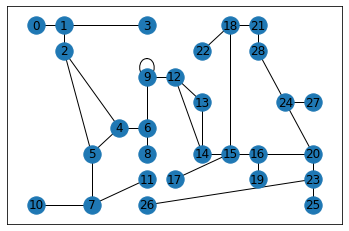

In [2]:
G = nx.Graph()
G.add_nodes_from([i for i in range(29)])
G.add_edges_from([(0,1),(1,2),(1,3),(2,4),(2,5),(4,5),(4,6),(5,7),
                  (6,8),(6,9),(7,10),(7,11),(9,9),(9,12),(12,13),(12,14),
                  (13,14),(14,15),(15,16),(15,17),(15,18),(16,19),(16,20),(18,21),
                  (18,22),(20,23),(20,24),(21,28),(21,28),(23,25),(23,26),(24,27),(24,28)])

pos = {}
pos[0] = (0,0)
pos[1] = (1,0)
pos[2] = (1,-1)
pos[3] = (4,0)
pos[4] = (3,-4)
pos[5] = (2,-5)
pos[6] = (4,-4)
pos[7] = (2,-7)
pos[8] = (4,-5)
pos[9] = (4,-2)
pos[10] = (0,-7)
pos[11] = (4,-6)
pos[12] = (5,-2)
pos[13] = (6,-3)
pos[14] = (6,-5)
pos[15] = (7,-5)
pos[16] = (8,-5)
pos[17] = (5,-6)
pos[18] = (7,0)
pos[19] = (8,-6)
pos[20] = (10,-5)
pos[21] = (8,0)
pos[22] = (6,-1)
pos[23] = (10,-6)
pos[24] = (9,-3)
pos[25] = (10,-7)
pos[26] = (4,-7)
pos[27] = (10,-3)
pos[28] = (8,-1)

nx.draw_networkx(G,pos=pos)

In [6]:
nbr_mtx=nx.to_numpy_matrix(G)

AttributeError: ignored

In [ ]:
#変数宣言

nt=20

#dt=1とする
nnodes=nx.number_of_nodes(G)
edge_list=list(G.edges)

conductivity=np.zeros((nt,nnodes,nnodes)) #D
length=np.zeros((nnodes,nnodes)) #L
pressure=np.zeros((nt,nnodes)) #p
flux=np.zeros(nnodes) #Q

In [ ]:
#初期値と定数の設定
conductivity[0]=nbr_mtx #各エッジの流れやすさは最初1.0

len_list = [1,1,3,5,9,2,1,2,1,2,2,3,8,1,2,4,2,1,2,3,5,1,3,1,4,1,3,1,5,1,7,3,3]
i=0
for u,v in G.edges():
    length[u][v]=len_list[i]
    length[v][u]=len_list[i]
    i +=1


I0=1.0

source_list=[0] #スタート
sink_list=[25] #ゴール

flux[0]=I0
flux[25]=-I0

gamma=1.5

In [ ]:
#ゼロ除算が発生しないように非ゼロ要素のみで割り算を行う
def divide_non_zero_element(D,L,num_nodes,list_edges):
    X=np.zeros((num_nodes,num_nodes))
    for i,j in list_edges:
        X[i,j]=D[i,j]/L[i,j]
        X[j,i]=D[j,i]/L[j,i]
    return X

#f(Q) for dD/dt 
def f(x):
    powered=x**gamma
    return powered/(powered+1)

#Dの時間変化量を求める
def dD(D,L,p,num_nodes,list_edges):
    X=divide_non_zero_element(D,L,num_nodes,list_edges)
    Q=np.multiply(X,np.expand_dims(p,axis=1)-p)
    ans=f(np.abs(Q))
    return ans

#一次連立方程式を解きpを求める
def deduce_p(D,L,B,num_nodes,list_edges):
    Y=divide_non_zero_element(D,L,num_nodes,list_edges)    
    A=np.diag(np.sum(Y,axis=1))-Y
    p=np.linalg.solve(A,B)
    #
    return p

In [ ]:
#pの初期値を求める
pressure[0]=deduce_p(conductivity[0],length,flux,nnodes,edge_list)

#繰り返し計算する
for t in range(0,nt-1):
    conductivity[t+1]=dD(conductivity[t],length,pressure[t],nnodes,edge_list)
    pressure[t+1]=deduce_p(conductivity[t+1],length,flux,nnodes,edge_list)

In [ ]:
#conductivityの出力
x = x = np.arange(nt)
y = [[] for t in range(nx.number_of_edges(G))]

for e in range(nx.number_of_edges(G)):
    e1 = edge_list[e][0]
    e2 = edge_list[e][1]
    for t in range(nt):
        y[e].append(conductivity[t][e1][e2])
    plt.plot(x,y[e])

plt.style.use('seaborn-whitegrid')
plt.title('Conductivity')
plt.show

In [ ]:
%matplotlib nbagg
fig=plt.figure(figsize=(8.8,6.6))

datatype=[('conductivity',float)]

def animate(i):
    A=np.matrix(conductivity[i],dtype=datatype)
    G=nx.from_numpy_matrix(A)
    weights=[G[u][v]['conductivity']*25 for u,v in G.edges()]

    plt.cla()
    nx.draw_networkx(G,pos,width=weights,node_size=20)
    nx.draw_networkx_nodes(G,pos,node_color=pressure[i],cmap=plt.cm.cool)
    plt.axis('off')
    plt.title('t=' + str(i))
    #plt.show()


# アニメーションの設定
ani = animation.FuncAnimation(fig,animate,frames=nt,repeat=True,interval=100)

# colabでアニメーションを動かすためのコード
rc('animation', html='jshtml')
ani